In [19]:
import numpy as np
import matplotlib.pyplot as plt
from SGD.sgd import SGD
from data.generate_synthetic_data import transform_to_polynomial
from sklearn.model_selection import train_test_split

In [20]:
np.random.seed(0)
d_values = [2,3,4,5]
l = 3
s = 0.0
noise = 0.0
max_n = 5000  
stepsize_methods = ["fixed", "halving", "diminishing"]

results = {}

In [21]:
for d in d_values:
    print(f"\n=== Running for d={d}, l={l} ===")

    lower_threshold_n = int((d)**(l+s))
    upper_threshold_n = int((d + 1)**(l + 1 + s))
    ns = np.unique(np.logspace(np.log10(lower_threshold_n / 2), np.log10(upper_threshold_n * 2), num=10, dtype=int))
    ns = [n for n in ns if n >= 5]
    
    X_raw = np.random.normal(0, 1, size=(max_n, d))
    X_true_poly = transform_to_polynomial(X_raw, degree=l, normalize=True)

    true_A = 0.001 * np.arange(1, X_true_poly.shape[1] + 1)
    true_b = 1.0
    y_full = X_true_poly @ true_A + true_b + np.random.normal(0, noise, size=max_n)

    results[(d, l)] = {method: {"train": [], "test": [], "ns": ns} for method in stepsize_methods}

    for n in ns:
        X_n = X_raw[:n]
        y_n = y_full[:n]
        X_poly_n = transform_to_polynomial(X_n, degree=l, normalize=True)

        X_train, X_test, y_train, y_test = train_test_split(X_poly_n, y_n, test_size=0.3)

        for method in stepsize_methods:
            sgd = SGD(X_train, y_train, num_iterations=n, noise=noise)
            w, obj, grad, dist = sgd.optimize(stepsize_type=method)

            train_loss = obj[-1]
            test_pred = X_test @ w[1:] + w[0]
            test_loss = np.mean((test_pred - y_test) ** 2)

            results[(d, l)][method]["train"].append(train_loss)
            results[(d, l)][method]["test"].append(test_loss)

            print(f"d={d}, l={l}, n={n}, {method}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}")



=== Running for d=2, l=3 ===
d=2, l=3, n=6, fixed: Train Loss=0.3351, Test Loss=1.2469
d=2, l=3, n=6, halving: Train Loss=0.3705, Test Loss=1.0240
d=2, l=3, n=6, diminishing: Train Loss=0.2952, Test Loss=1.6700
d=2, l=3, n=9, fixed: Train Loss=0.4658, Test Loss=0.9508
d=2, l=3, n=9, halving: Train Loss=0.4472, Test Loss=1.0717
d=2, l=3, n=9, diminishing: Train Loss=0.4591, Test Loss=1.0855
d=2, l=3, n=13, fixed: Train Loss=0.3823, Test Loss=0.9025
d=2, l=3, n=13, halving: Train Loss=0.3973, Test Loss=0.9409
d=2, l=3, n=13, diminishing: Train Loss=0.3736, Test Loss=0.9424
d=2, l=3, n=20, fixed: Train Loss=0.3431, Test Loss=0.7721
d=2, l=3, n=20, halving: Train Loss=0.3087, Test Loss=0.9344
d=2, l=3, n=20, diminishing: Train Loss=0.2988, Test Loss=0.7979
d=2, l=3, n=31, fixed: Train Loss=0.3226, Test Loss=0.6936
d=2, l=3, n=31, halving: Train Loss=0.3076, Test Loss=0.6391
d=2, l=3, n=31, diminishing: Train Loss=0.3204, Test Loss=0.6430
d=2, l=3, n=47, fixed: Train Loss=0.2211, Test Loss

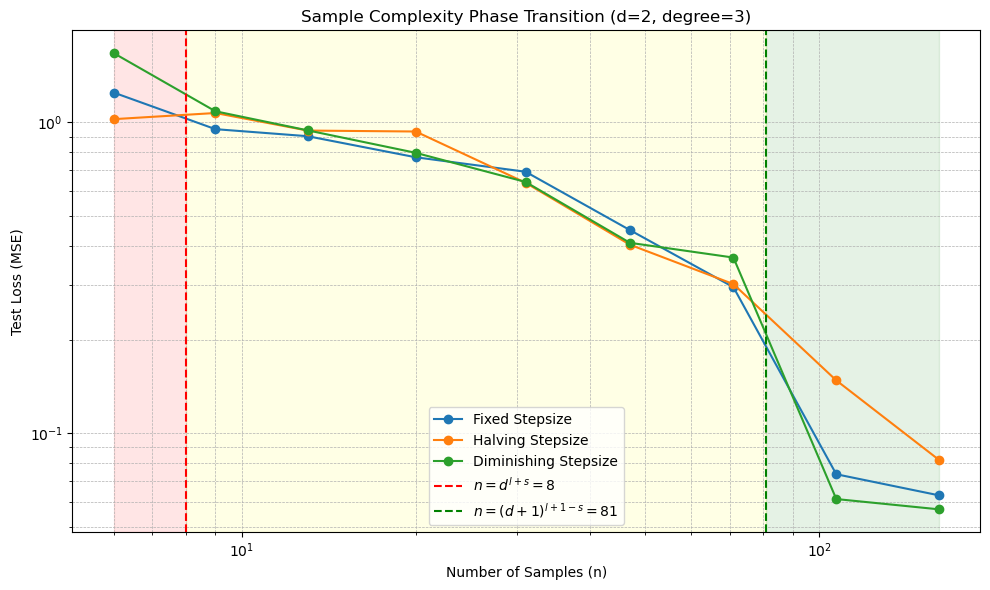

In [ ]:
d_plot = 2
l_plot = 3
ns_plot = results[(d_plot, l_plot)]["fixed"]["ns"]

plt.figure(figsize=(10, 6))

for method in stepsize_methods:
    test_losses_plot = results[(d_plot, l_plot)][method]["test"]
    plt.plot(ns_plot, test_losses_plot, label=f"{method.capitalize()} Stepsize", marker='o')

lower_threshold_n = d_plot ** (l_plot + s)
upper_threshold_n = (d_plot + 1) ** (l_plot + 1 - s)

plt.axvline(lower_threshold_n, color='red', linestyle='--', label=f"$n = d^{{l+s}} = {int(lower_threshold_n)}$")
plt.axvline(upper_threshold_n, color='green', linestyle='--', label=f"$n = (d+1)^{{l+1-s}} = {int(upper_threshold_n)}$")
plt.axvspan(ns_plot[0], lower_threshold_n, color='red', alpha=0.1)
plt.axvspan(lower_threshold_n, upper_threshold_n, color='yellow', alpha=0.1)
plt.axvspan(upper_threshold_n, ns_plot[-1], color='green', alpha=0.1)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (n)")
plt.ylabel("Test Loss (MSE)")
plt.title(f"Phase Transition (d={d_plot}, degree={l_plot})")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

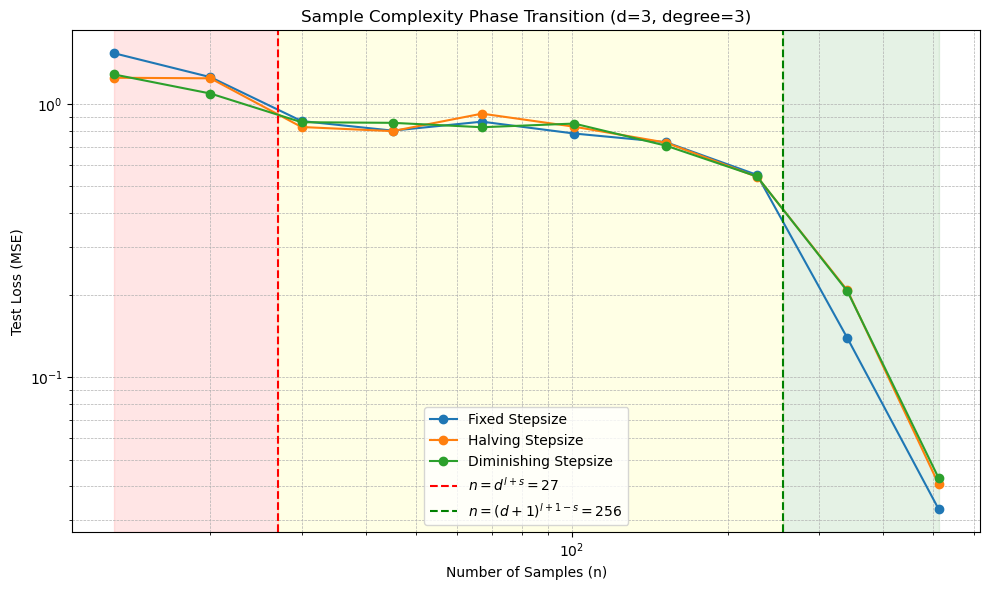

In [ ]:
d_plot = 3
l_plot = 3
ns_plot = results[(d_plot, l_plot)]["fixed"]["ns"]

plt.figure(figsize=(10, 6))

for method in stepsize_methods:
    test_losses_plot = results[(d_plot, l_plot)][method]["test"]
    plt.plot(ns_plot, test_losses_plot, label=f"{method.capitalize()} Stepsize", marker='o')

lower_threshold_n = d_plot ** (l_plot + s)
upper_threshold_n = (d_plot + 1) ** (l_plot + 1 - s)

plt.axvline(lower_threshold_n, color='red', linestyle='--', label=f"$n = d^{{l+s}} = {int(lower_threshold_n)}$")
plt.axvline(upper_threshold_n, color='green', linestyle='--', label=f"$n = (d+1)^{{l+1-s}} = {int(upper_threshold_n)}$")
plt.axvspan(ns_plot[0], lower_threshold_n, color='red', alpha=0.1)
plt.axvspan(lower_threshold_n, upper_threshold_n, color='yellow', alpha=0.1)
plt.axvspan(upper_threshold_n, ns_plot[-1], color='green', alpha=0.1)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (n)")
plt.ylabel("Test Loss (MSE)")
plt.title(f"Phase Transition (d={d_plot}, degree={l_plot})")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

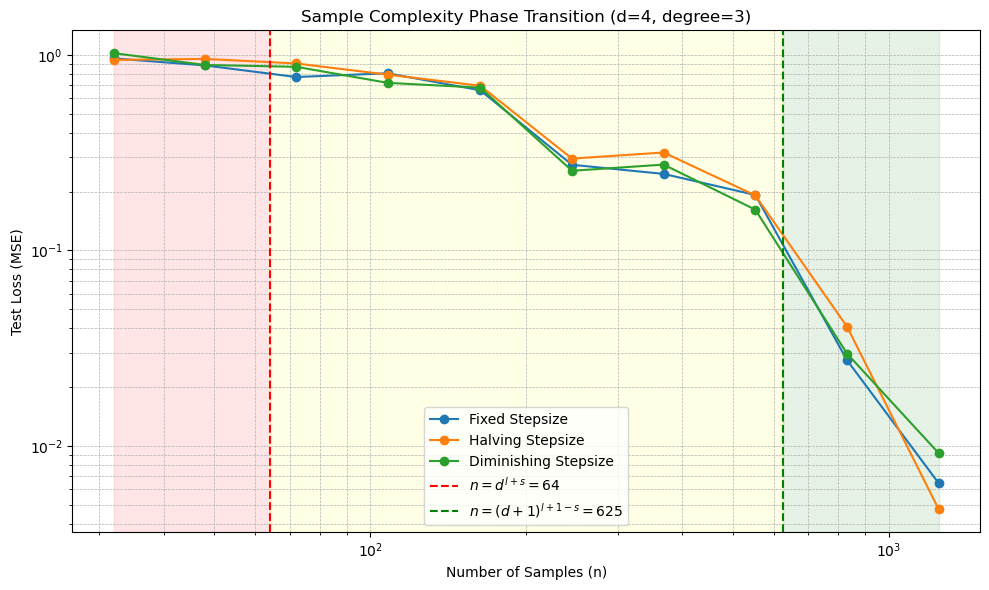

In [ ]:
d_plot = 4
l_plot = 3
ns_plot = results[(d_plot, l_plot)]["fixed"]["ns"]

plt.figure(figsize=(10, 6))

for method in stepsize_methods:
    test_losses_plot = results[(d_plot, l_plot)][method]["test"]
    plt.plot(ns_plot, test_losses_plot, label=f"{method.capitalize()} Stepsize", marker='o')

lower_threshold_n = d_plot ** (l_plot + s)
upper_threshold_n = (d_plot + 1) ** (l_plot + 1 - s)

plt.axvline(lower_threshold_n, color='red', linestyle='--', label=f"$n = d^{{l+s}} = {int(lower_threshold_n)}$")
plt.axvline(upper_threshold_n, color='green', linestyle='--', label=f"$n = (d+1)^{{l+1-s}} = {int(upper_threshold_n)}$")
plt.axvspan(ns_plot[0], lower_threshold_n, color='red', alpha=0.1)
plt.axvspan(lower_threshold_n, upper_threshold_n, color='yellow', alpha=0.1)
plt.axvspan(upper_threshold_n, ns_plot[-1], color='green', alpha=0.1)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (n)")
plt.ylabel("Test Loss (MSE)")
plt.title(f"Phase Transition (d={d_plot}, degree={l_plot})")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

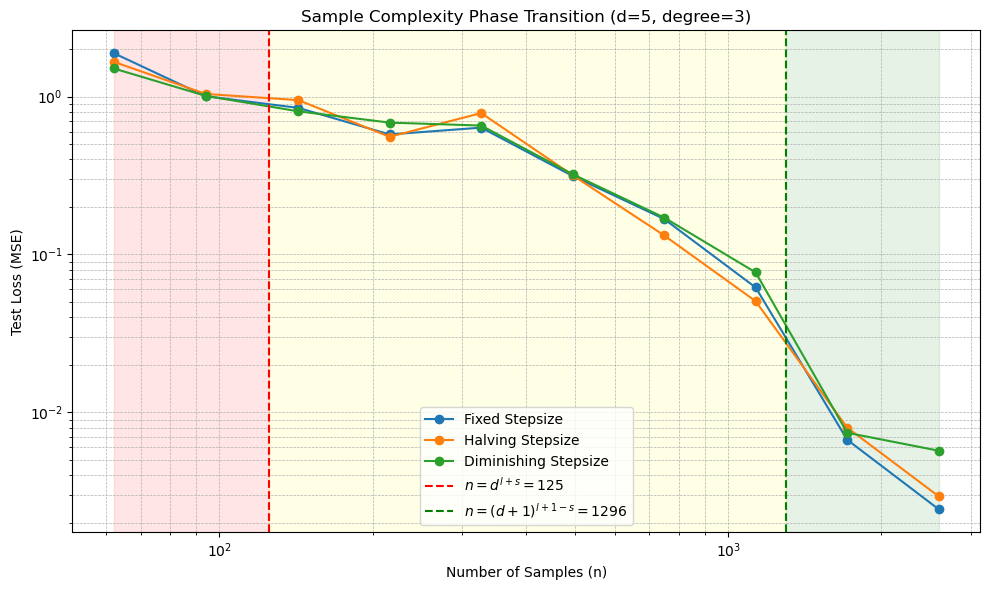

In [ ]:
d_plot = 5
l_plot = 3
ns_plot = results[(d_plot, l_plot)]["fixed"]["ns"]

plt.figure(figsize=(10, 6))

for method in stepsize_methods:
    test_losses_plot = results[(d_plot, l_plot)][method]["test"]
    plt.plot(ns_plot, test_losses_plot, label=f"{method.capitalize()} Stepsize", marker='o')

lower_threshold_n = d_plot ** (l_plot + s)
upper_threshold_n = (d_plot + 1) ** (l_plot + 1 - s)

plt.axvline(lower_threshold_n, color='red', linestyle='--', label=f"$n = d^{{l+s}} = {int(lower_threshold_n)}$")
plt.axvline(upper_threshold_n, color='green', linestyle='--', label=f"$n = (d+1)^{{l+1-s}} = {int(upper_threshold_n)}$")
plt.axvspan(ns_plot[0], lower_threshold_n, color='red', alpha=0.1)
plt.axvspan(lower_threshold_n, upper_threshold_n, color='yellow', alpha=0.1)
plt.axvspan(upper_threshold_n, ns_plot[-1], color='green', alpha=0.1)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Samples (n)")
plt.ylabel("Test Loss (MSE)")
plt.title(f"Phase Transition (d={d_plot}, degree={l_plot})")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()